In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.utils.data import Dataset,DataLoader
# from diffusion_utilities import *
class EmbedFC(nn.Module):
    def __init__(self,input_dim,emb_dim):
        super(EmbedFC,self).__init__()
        self.input_dim=input_dim
        layers=[
            nn.Linear(input_dim,emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim,emb_dim)
        ]
        self.model=nn.Sequential(*layers)
    def forward(self,x):
        x=x.view(-1,self.input_dim)
        return self.model(x)

class ResidualConvBlock(nn.Module):
    def __init__(self,in_channels:int,out_channels:int,is_res:bool=False):
        super().__init__()
        self.same_channels=in_channels==out_channels
        self.is_res=is_res
        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,1,1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )
        self.conv2=nn.Sequential(
            nn.Conv2d(out_channels,out_channels,3,1,1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )
    def forward(self,x:torch.Tensor)->torch.Tensor:
        if self.is_res:
            x1=self.conv1(x)
            x2=self.conv2(x1)
            if self.same_channels:
                out=x+x2
            else:
                shortcut=nn.Conv2d(x.shape[1],x2.shape[1],kernel_size=1,stride=1,padding=0).to(x.device)
                out=shortcut(x)+x2
            return out/1.414
        else:
            x1=self.conv1(x)
            x2=self.conv2(x1)
            return x2
    def get_out_channels(self):
        return self.conv2[0].out_channels
    def set_out_channels(self,out_channels):
        self.conv1[0].out_channels=out_channels
        self.conv2[0].in_channels=out_channels
        self.conv2[0].out_channels=out_channels

class UnetDown(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(UnetDown,self).__init__()
        layers=[ResidualConvBlock(in_channels,out_channels),
                ResidualConvBlock(out_channels,out_channels),
                nn.MaxPool2d(2)]
        self.model=nn.Sequential(*layers)
    def forward(self,x):
        return self.model(x)
    
class UnetUp(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(UnetUp,self).__init__()
        layers=[
            nn.ConvTranspose2d(in_channels,out_channels,2,2),
            ResidualConvBlock(out_channels,out_channels),
            ResidualConvBlock(out_channels,out_channels)
        ]
        self.model=nn.Sequential(*layers)
    def forward(self,x,skip):
        x=torch.cat((x,skip),1)
        x=self.model(x)
        return x

class ContextUnet(nn.Module):
    def __init__(self,in_channels,n_feat=256,n_cfeat=1):
        super(ContextUnet,self).__init__()
        self.in_channels=in_channels
        self.n_feat=n_feat
        self.n_cfeat=n_cfeat
        # self.h=height

        self.init_conv=ResidualConvBlock(in_channels,n_feat,is_res=True)
        self.down1=UnetDown(n_feat,n_feat)
        self.down2=UnetDown(n_feat,2*n_feat)
        self.down3=UnetDown(2*n_feat,4*n_feat)
        
        self.to_vec=nn.Sequential(nn.AvgPool2d((5)),nn.GELU())

        self.timeembed0=EmbedFC(1,4*n_feat)
        self.timeembed1=EmbedFC(1,2*n_feat)
        self.timeembed2=EmbedFC(1,1*n_feat)
        self.contextembed0=EmbedFC(n_cfeat,4*n_feat)
        self.contextembed1=EmbedFC(n_cfeat,2*n_feat)
        self.contextembed2=EmbedFC(n_cfeat,1*n_feat)

        self.up0=nn.Sequential(
            nn.ConvTranspose2d(4*n_feat,4*n_feat,5,5),
            nn.GroupNorm(8,4*n_feat),
            nn.ReLU()
        )
        self.up1=UnetUp(2*4*n_feat,2*n_feat)
        self.up2=UnetUp(2*2*n_feat,n_feat)
        self.up3=UnetUp(2*n_feat,n_feat)
        self.out=nn.Sequential(
            nn.Conv2d(2*n_feat,n_feat,3,1,1),
            nn.GroupNorm(8*2,n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat,self.in_channels,3,1,1)
        )
    def forward(self,x,c=None):
        x=self.init_conv(x)
        down1=self.down1(x)
        down2=self.down2(down1)
        down3=self.down3(down2)
        hiddenvec=self.to_vec(down3)
        if c is None:
            c=torch.zeros(x.shape[0],self.n_cfeat).to(x)
        cemb0=self.contextembed0(c).view(-1,self.n_feat*4,1,1)
        # temb0=self.timeembed0(t).view(-1,self.n_feat*4,1,1)
        cemb1=self.contextembed1(c).view(-1,self.n_feat*2,1,1)
        # temb1=self.timeembed1(t).view(-1,self.n_feat*2,1,1)
        cemb2=self.contextembed2(c).view(-1,self.n_feat,1,1)
        # temb2=self.timeembed2(t).view(-1,self.n_feat,1,1)

        up1=self.up0(hiddenvec)
        up2=self.up1(cemb0*up1,down3)
        up3=self.up2(cemb1*up2,down2)
        up4=self.up3(cemb2*up3,down1)
        out=self.out(torch.cat((up4,x),1))
        return out
    
# class MLP(nn.Module):
#     def __init__(self):
#         super(MLP,self).__init__()
#         self.fc1=nn.Linear(579,1024)
#         self.fc2=nn.Linear(1024,512)
#         self.fc3=nn.Linear(512,2)
#     def forward(self,x):
#         x=F.relu(self.fc1(x))
#         x=F.relu(self.fc2(x))
#         x=self.fc3(x)
#         return x

In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

q_avg=np.empty((0,1))
Crate_idx=[2,5,6,7,8,9,12,13,14]
tempdata1=np.empty((0,578))
tempdata2=np.empty((0,578))
tempdata=np.empty((0,578))

for i in Crate_idx:
    dataPath=f'./dataset{i}'
    load_data=np.load(dataPath+'/cell.npz')
    Temp=load_data['temperature']
    q_lenth=len(Temp)-1
    Qg=np.loadtxt(dataPath+'/q_avg.txt')[:q_lenth]
    q_avg=np.concatenate((q_avg,Qg.reshape(-1,1)))
    tempdata1=np.concatenate((tempdata1,Temp[0:-1]),axis=0)
    tempdata2=np.concatenate((tempdata2,Temp[1:]),axis=0)
    # tempdata=np.concatenate((tempdata,min_max_normalize_3d(Temp[0:-1])),axis=0)

def minmax_normalize(data, min_val=None, max_val=None):
    data = np.asarray(data)
    if min_val is None:
        min_val = np.min(data)
    if max_val is None:
        max_val = np.max(data)

    if max_val == min_val:
        return np.ones_like(data)*0.5
    
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data,[min_val, max_val]

def minmax_denormalize(normalized_data, min_val, max_val):
    normalized_data = np.asarray(normalized_data)
    denormalized_data = normalized_data * (max_val - min_val) + min_val
    return denormalized_data


import matplotlib.pyplot as plt
from scipy.interpolate import SmoothBivariateSpline

Position=load_data['position']
x=np.linspace(0,0.009,40)
y=np.linspace(0,0.017997,40)
yy,xx=np.meshgrid(y,x)

xd=[]
yd=[]

for i in range(len(tempdata2)):
    f_interp=SmoothBivariateSpline(Position[0],Position[1],tempdata2[i])
    yd.append(f_interp.ev(yy,xx).transpose())
    f_interp=SmoothBivariateSpline(Position[0],Position[1],tempdata1[i])
    xd.append(f_interp.ev(yy,xx).transpose())


In [3]:
xdata=[]
ydata=[]
xminmax=[]
yminmax=[]
xflatten=[]

for i in range(len(xd)):
    x1,x2=minmax_normalize(xd[i])
    xdata.append(x1)
    xminmax.append(x2)
    y1,y2=minmax_normalize(yd[i])
    ydata.append(y1)
    yminmax.append(y2)
    xflatten.append(xd[i].flatten()[np.linspace(0,1599,400,dtype=int)])

xdata=np.array(xdata).astype(np.float32)
ydata=np.array(ydata).astype(np.float32)
xminmax=np.array(xminmax).astype(np.float32)
yminmax=np.array(yminmax).astype(np.float32)
q_avg=np.array(q_avg).astype(np.float32)
xflatten=np.array(xflatten).astype(np.float32)
emb=np.concatenate((xflatten,q_avg),axis=1)

embscaler=MinMaxScaler(feature_range=(0,1))
emb=embscaler.fit_transform(emb)

np.random.seed(42)
array=np.arange(32568)
index=np.random.choice(array,3000,replace=False)

v_xdata=xdata[index]
v_ydata=ydata[index]
v_emb=emb[index]

t_xdata=np.delete(xdata,index,axis=0)
t_ydata=np.delete(ydata,index,axis=0)
t_emb=np.delete(emb,index,axis=0)

t_xdata.shape,t_ydata.shape,t_emb.shape,v_xdata.shape,v_ydata.shape,v_emb.shape


((29568, 40, 40),
 (29568, 40, 40),
 (29568, 401),
 (3000, 40, 40),
 (3000, 40, 40),
 (3000, 401))

In [4]:
from torch.utils.data import DataLoader,Dataset
class TrainDataset(Dataset):
    def __init__(self,x,y,e):
        self.x=x
        self.y=y
        self.e=e
    def __len__(self):
        return len(self.x)
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx],self.e[idx]
    
train_dataset=TrainDataset(t_xdata,t_ydata,t_emb)
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)

val_dataset=TrainDataset(v_xdata,v_ydata,v_emb)
val_loader=DataLoader(val_dataset,batch_size=10,shuffle=True)

100%|██████████| 500/500 [27:06:50<00:00, 195.22s/it]   


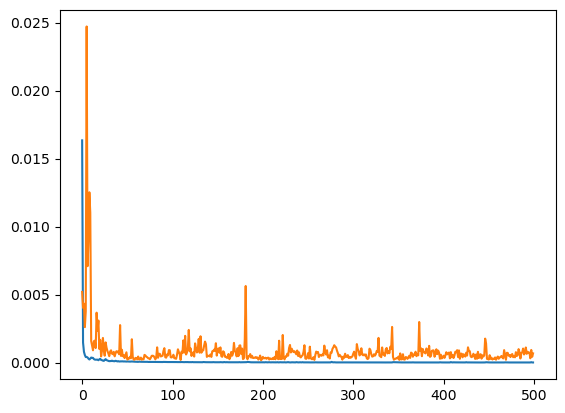

In [5]:
from tqdm import tqdm
import os

device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device='cpu'

u_model=ContextUnet(in_channels=1,n_feat=256,n_cfeat=401).to(device)

lrate=0.0001
n_epoch=500
optim=torch.optim.Adam(u_model.parameters(),lr=lrate)
criterion=nn.MSELoss()

tlosslist=[]
vlosslist=[]
if os.path.isfile('Unet20250620'):
    u_model.load_state_dict(torch.load('Unet20250620'))
else:
    for epoch in tqdm(range(n_epoch)):
        u_model.train()
        tlosses=0.0
        #optim.param_groups[0]['lr']=lrate*(1-epoch/n_epoch)
        for xb,yb,eb in train_loader:
            optim.zero_grad()
            xb,yb,eb=xb.unsqueeze(1).to(device),yb.unsqueeze(1).to(device),eb.to(device)
            pred=u_model(xb,eb)
            tloss=criterion(pred,yb)
            tloss.backward()
            optim.step()
            tlosses+=tloss.item()
        u_model.eval()
        vlosses=0.0
        for xv,yv,ev in val_loader:
            xv,yv,ev=xv.unsqueeze(1).to(device),yv.unsqueeze(1).to(device),ev.to(device)
            vpred=u_model(xv,ev)
            vloss=criterion(vpred,yv)
            vlosses+=vloss.item()
        tlosslist.append(tlosses/len(train_loader))
        vlosslist.append(vlosses/len(val_loader))

plt.plot(tlosslist)
plt.plot(vlosslist)

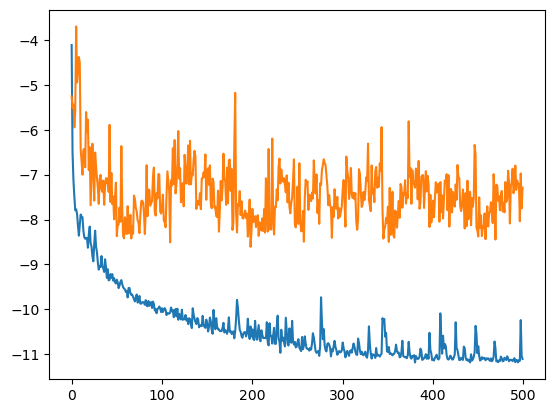

In [6]:
plt.plot(np.log(tlosslist))
plt.plot(np.log(vlosslist))

In [7]:
torch.save(u_model.state_dict(),'unet20250620')

In [8]:
for xv,yv,ev in val_loader:
    xv,yv,ev=xv.unsqueeze(1).to(device),yv.unsqueeze(1).to(device),ev.to(device)
    vpred=u_model(xv,ev)
    break

In [12]:
pred_img=vpred[0,0].detach().cpu().numpy()

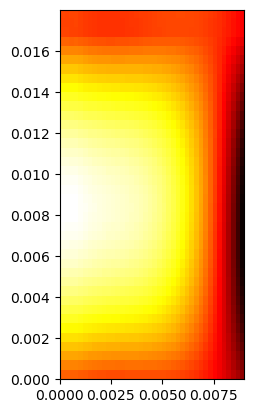

In [13]:
plt.imshow(pred_img,cmap='hot',interpolation='nearest',extent=(0,0.018/2,0,0.017997))